# Attachment 2 to Assignment 8.1 
### ECE 517, Professor Martinez-Ramon, Student: Zachary Montoya
Sliding windowed GPR with a linear and radial basis function (RBF) kernel on load recorded in Connecticut of 2020 and 2021 with a variable "Look-a-head" and sliding window of 96 hours. 

In [1]:
import numpy as np
from sklearn import preprocessing
from matplotlib.ticker import LinearLocator
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, DotProduct

class SlidingGPR:

    """ 
    This is a GPR with a sliding window function \n 
    It accepts data that is in the form of a 1D column \n

    Instructions:
    1. Import the training data using the import_data method
    2. Scale the training data using the scale_data method
    3. Train the GP using the train_gp method
    
    4. Import the test data using the import_data method
        (Note: New test data can be used without retraining the GP)
    5. Scale the test data using the scale_data method
    6. Predict the GP using the predict_gp method
    7. Plot the GP results using the plot_gp_results method
    8. Print the GP performance using the gp_performance method (optional)
    9. Plot the test and training data using the plot_test_train method (optional)
    10. Plot the windowed surface of the training data using the plot_windowed_surface method (optional) 
    """
    def __init__(self):
        # Training Data
        self.training_data = None
        self.train_start = None
        self.train_end = None
        self.scaler = None
        self.training_data_scaled = None
        self.training_data_windowed = None
        self.y_train = None

        # Test Data
        self.test_data = None
        self.test_start = None
        self.test_end = None
        self.test_data_scaled = None
        self.test_data_windowed = None
        self.y_test = None

        # Window
        self.window = None      # W
        self.lookahead = None   # M
        self.overlap = None     # Overlap
        
        # Kernel
        self.kernel = None
        self.gp = None
        self.mean_pred = None
        self.y_test_transformed = None
        self.mean_pred_transformed = None
        self.std_pred = None
        self.std_pred_transformed = None


    def check_dimension(self, data):
        """
        Checks the dimension of the data and reshapes it if necessary
        """
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        return data
    
    def scale_data(self, data, IsTrainDataSet=False):
        """
        Scales the data to be between 0 and 1
        """
        if IsTrainDataSet:    
            self.scaler = preprocessing.StandardScaler().fit(data)
            self.training_data_scaled = self.scaler.transform(data)
        else:
            self.test_data_scaled = self.scaler.transform(data)

    def import_data(self, data, start, end, IsTrainDataSet=False):
        """
        Imports the data
        """
        data = np.array(data)
        data = self.check_dimension(data)
        if IsTrainDataSet:
            self.training_data = data
            self.train_start = start
            self.train_end = end
        else:
            self.test_data = data
            self.test_start = start
            self.test_end = end

    def plot_test_train(self, title1=None, title2=None):
        """
        Plots the test and training data
        """
        if self.training_data is None or self.test_data is None:
            print("Please import the data first")
            return
        
        else:
            plt.figure(figsize=(8,10))

            plt.subplot(2,1,1)
            plt.plot(self.test_data[self.test_start:self.test_end],marker = 'o', label='Test Data')
            plt.plot(self.training_data[self.train_start:self.test_end],marker = 'x', label='Training Data')
            if title1 is not None: plt.title(title1)
            else: plt.title("Test Data and Training Data at x-scale of Training Data")
            plt.legend()

            plt.subplot(2,1,2)
            plt.plot(self.test_data[self.test_start:self.test_end],marker = 'o', label='Test Data')
            plt.plot(self.training_data[self.train_start:self.train_end],marker = 'x', label='Training Data')
            if title2 is not None: plt.title(title2)
            else: plt.title("Test Data and Training Data at x-scale of Test Data")
            plt.legend()

            plt.show()

    def sliding_window(self,x, w = 1, d = 0):
        """
        This function creates a sliding window of the data. 
        It was taken from Professor Martinez-Ramon's google colab notebook:
        https://colab.research.google.com/drive/1tFmix6CHXGC9Mbs3kJWWx1GKZJ2t-3uV
        x = data
        w = window size
        d = overlap
        """
        N = len(x)
        x=x.reshape(x.size,) 
        m = int(np.ceil((N-w)/(w-d)))
        X = np.zeros([w,m])
        for i,j in zip(range(0,N,w-d),range(0,m)):
            X[:,j] = x[i:i + w]
        return X
    
    def plot_graphs(y_tst,mean,std,title):
        """
        this method plots the graphs of the test data, mean, and standard deviation
            y_tst is the time series of true regressors
            mean is the mean value of the prediction
            std is the standard deviation of the prediction
            title is a string with the title that you want to show in the graphic.
        It was taken from Professor Martinez-Ramon's google colab notebook:
        https://colab.research.google.com/drive/1tFmix6CHXGC9Mbs3kJWWx1GKZJ2t-3uV

        """
        plt.plot(y_tst, label="Observations",color="black")
        plt.plot(mean, label="Mean prediction",color="red")
        plt.fill_between(
            np.arange(y_tst.size).ravel(),
            mean - 1.96 * std,
            mean + 1.96 * std,
            alpha=0.5,
            label=r"95% confidence interval",
        )
        plt.legend()
        plt.xlabel("$t$")
        plt.ylabel("$f(t)$")
        plt.title(title)
        plt.show()
    
    def plot_windowed_surface(self,data):
        """
        Plots the windowed surface of the data
        """
        if self.training_data_windowed is None:
            print("Please train the GP first")
            return
        else:
            X = np.arange(0, data.shape[1],1)
            Y = np.arange(0, data.shape[0],1)
            X, Y = np.meshgrid(X, Y)

            fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
            surf = ax.plot_wireframe(X,Y,data,antialiased=True)
            ax.zaxis.set_major_locator(LinearLocator(10))
            ax.zaxis.set_major_formatter('{x:.02f}')
            plt.show()

    def train_gp(self, kernel, window, lookahead, overlap):
        """
        Trains the GP on the imported training data
        """
        # Checking if the data has been imported
        if self.scaler is None:
            print("Please scale the data first")
            return
        
        # Checkinf if lookahead is greater than window
        if lookahead > window:
            print("Lookahead cannot be greater than window")
            return
        
        # Checking if lookahead is greater than 24 hours
        elif lookahead > 24:
            print("Lookahead cannot be greater than 24 hours")
            return
        
        # Checking if the window is between 24 and 168 hours
        elif window < 24 or window > 168:
            print("Window must be between 24 and 168 hours")
            return
        else:    
            self.kernel = kernel
            self.window = window
            self.lookahead = lookahead
            self.overlap = overlap

            training_data_scaled = self.training_data_scaled
            training_data_windowed = self.sliding_window(training_data_scaled[:-self.lookahead], self.window, self.window - self.overlap).T
            self.training_data_windowed = training_data_windowed[self.train_start:self.train_end]
            y_train = training_data_scaled[self.window+self.lookahead-self.overlap:].flatten()
            self.y_train  = y_train[self.train_start:self.train_end]
            self.gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
            self.gp.fit(self.training_data_windowed, self.y_train)
            

    def predict_gp(self,test_data):
        """
        Predicts the GP on the most recently imported test data

        """
        if self.y_train is None:
            print("Please train the GP first")
            return
        else:  
            test_data_scaled = self.test_data_scaled
            test_data_windowed = self.sliding_window(test_data_scaled[:-self.lookahead], self.window, self.window - self.overlap).T
            self.test_data_windowed = test_data_windowed[self.test_start:self.test_end]
            y_test = test_data_scaled[self.window+self.lookahead-self.overlap:].flatten()
            self.y_test  = y_test[self.test_start:self.test_end]
            self.mean_pred, self.std_pred = self.gp.predict(self.test_data_windowed, return_std=True)

    def plot_gp_results(self,kerneltypetitle):
        """
        Plots the GP results of the most recently predicted test data
        """
        if self.y_test is None:
            print("Please test the GP first")
            return
        else:
            self.y_test_transformed = self.scaler.inverse_transform(self.y_test.reshape(-1,1))
            self.mean_pred_transformed = self.scaler.inverse_transform(self.mean_pred.reshape(-1,1))
            std_train_data = np.std(self.training_data)
            mean_train_data = np.mean(self.training_data)
            self.std_pred_transformed = self.std_pred * std_train_data

            title = str(kerneltypetitle) + " GP Results with a W: " + str(self.window) + " and a M: " + str(self.lookahead)
            plt.plot(self.y_test_transformed, label="Observations",color="black")
            plt.plot(self.mean_pred_transformed, label="Mean prediction",color="red")
            plt.fill_between(
                np.arange(self.y_test_transformed.size).ravel(),
                self.mean_pred_transformed.ravel() - 1.96 * self.std_pred_transformed,
                self.mean_pred_transformed.ravel() + 1.96 * self.std_pred_transformed,
                alpha=0.5,
                label=r"95% confidence interval",
            )
            plt.legend()
            plt.xlabel("$t$")
            plt.ylabel("$f(t)$")
            plt.title(title)
            plt.show()

    def gp_performance(self):
        """
        Prints the GP performance 
        Counts the number of times the test data is within 1 & 2 standard deviation of the mean prediction
        """
        if self.mean_pred is None:
            print("Please train the GP first")
            return
        else:
              
            print(f"GP score on training data:  {self.gp.score(self.training_data_windowed, self.y_train):.2f}")
            print(f"GP score on test data:      {self.gp.score(self.test_data_windowed, self.y_test):.2f}")
            print(f"GP kernel:                  {self.gp.kernel_}")

In [2]:
import pandas as pd
import os

In [3]:
# Getting the file path, names, and creating an empty dataframe
cwd = os.getcwd()
data_path = os.path.join(cwd,'ISO data')
data_files = os.listdir(data_path)
df_data = pd.DataFrame()

# Concatenating the data into a single dataframe and updating the column names based on the file names
column_list = []
for file in data_files:
    if file.endswith('.txt'):
        df = pd.read_csv(os.path.join(data_path,file),header=None)
        df_data = pd.concat([df_data,df],axis=1)
    column_list.append(file.split('.')[0])
df_data.columns = column_list
df_data.describe()

,2021_VT,2021_CT,2021_RI,2021_NEMA,2020_NEMA,2020_NH,2020_ME,2020_CT,2020_VT,2020_SEMA,2021_SEMA,2020_RI,2020_WCMA,2021_WCMA,2021_ME,2021_NH
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,573.733680,3178.607189,888.604614,2650.611943,2605.428944,1282.360558,1289.352365,3134.541049,564.493640,1558.803687,1587.659309,868.768596,1778.561567,1815.663676,1334.266356,1304.722928
std,116.435296,714.520490,201.795738,533.453800,532.844297,266.295741,216.000574,732.184415,114.193109,387.202587,383.459369,209.054681,350.883200,345.873055,218.795629,262.826201
min,193.580000,1927.420000,549.690000,1738.940000,1665.770000,769.480000,738.000000,1859.180000,178.110000,957.070000,813.810000,522.180000,1119.620000,1153.300000,872.930000,794.220000
25%,493.057500,2696.355000,755.085000,2288.977500,2219.670000,1090.935000,1124.975000,2613.880000,484.955000,1282.385000,1322.105000,728.865000,1516.895000,1567.575000,1181.755000,1120.107500
50%,575.615000,3076.320000,859.620000,2586.315000,2544.790000,1263.455000,1290.860000,3032.990000,564.000000,1495.125000,1520.585000,837.445000,1740.370000,1775.795000,1331.980000,1287.905000
75%,654.302500,3553.245000,978.015000,2921.877500,2893.440000,1432.157500,1437.682500,3498.882500,645.475000,1733.590000,1777.132500,953.562500,1989.392500,2024.375000,1477.977500,1458.925000
max,886.030000,6504.650000,1840.790000,5220.140000,4998.350000,2402.190000,2023.220000,6303.070000,885.450000,3366.460000,3454.000000,1873.670000,3208.450000,3317.440000,2325.820000,2462.240000


# Linear Kernel M = 1

In [4]:
# Training the GP with a linear kernel
LinearGP = SlidingGPR()

# Training Data from 0 to 1000 hrs
LinearGP.import_data(df_data['2020_CT'], 0, 1000, IsTrainDataSet=True) 
LinearGP.scale_data(LinearGP.training_data, IsTrainDataSet=True)

# Setting the window, lookahead, and overlap
window = 96
lookahead = 1 # M
overlap = 1
kernel = 1 * DotProduct() + WhiteKernel()

# Training the GP
LinearGP.train_gp(kernel, window, lookahead, overlap)

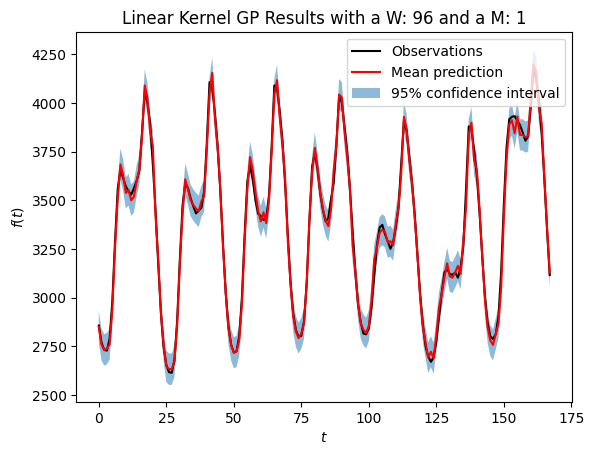

GP score on training data:  0.99
GP score on test data:      0.99
GP kernel:                  0.287**2 * DotProduct(sigma_0=0.0206) + WhiteKernel(noise_level=0.00289)


In [5]:
# Test Data from January 1, 2021 to January 7, 2021
LinearGP.import_data(df_data['2021_CT'], 0, 24*7)
LinearGP.scale_data(LinearGP.test_data)
LinearGP.predict_gp(LinearGP.test_data)
LinearGP.plot_gp_results("Linear Kernel")
LinearGP.gp_performance()

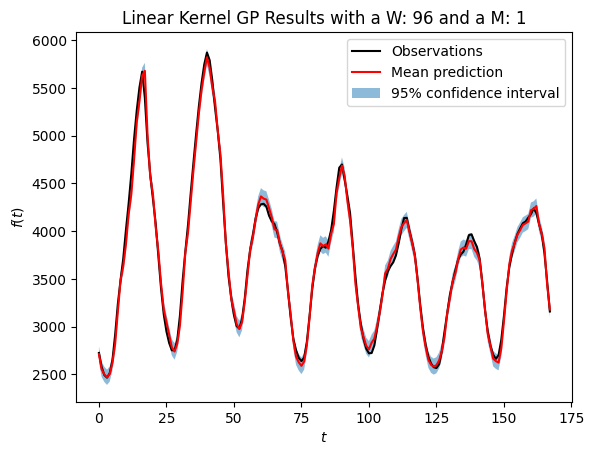

GP score on training data:  0.99
GP score on test data:      0.99
GP kernel:                  0.287**2 * DotProduct(sigma_0=0.0206) + WhiteKernel(noise_level=0.00289)


In [6]:
# Test Data from July 1, 2021 to July 7, 2021
LinearGP.import_data(df_data['2021_CT'], 182*24, 189*24)
LinearGP.scale_data(LinearGP.test_data)
LinearGP.predict_gp(LinearGP.test_data)
LinearGP.plot_gp_results("Linear Kernel")
LinearGP.gp_performance()

# RBF M = 1

In [7]:
# Training the GP with a RBF kernel
RBFGP = SlidingGPR()

# Training Data from 0 to 1000 hrs
RBFGP.import_data(df_data['2020_CT'], 0, 1000, IsTrainDataSet=True) 
RBFGP.scale_data(RBFGP.training_data, IsTrainDataSet=True)

# Setting the window, lookahead, and overlap
window = 96
lookahead = 1 # M
overlap = 1
kernel = 1 * RBF() + WhiteKernel()

# Training the GP
RBFGP.train_gp(kernel, window, lookahead, overlap)

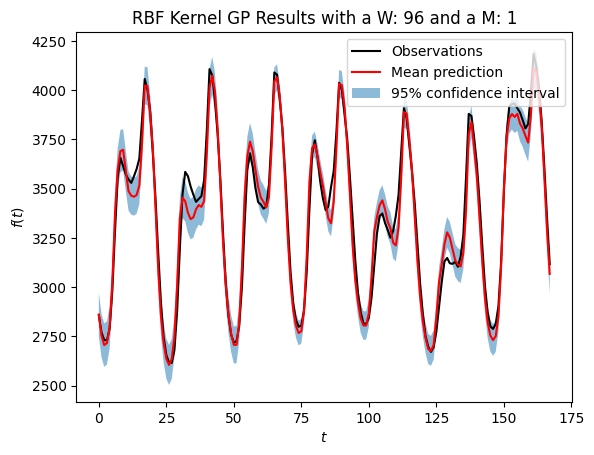

GP score on training data:  1.00
GP score on test data:      0.97
GP kernel:                  0.908**2 * RBF(length_scale=7.05) + WhiteKernel(noise_level=0.000181)


In [8]:
# Test Data from January 1, 2021 to January 7, 2021
RBFGP.import_data(df_data['2021_CT'], 0, 24*7)
RBFGP.scale_data(RBFGP.test_data)
RBFGP.predict_gp(RBFGP.test_data)
RBFGP.plot_gp_results("RBF Kernel")
RBFGP.gp_performance()

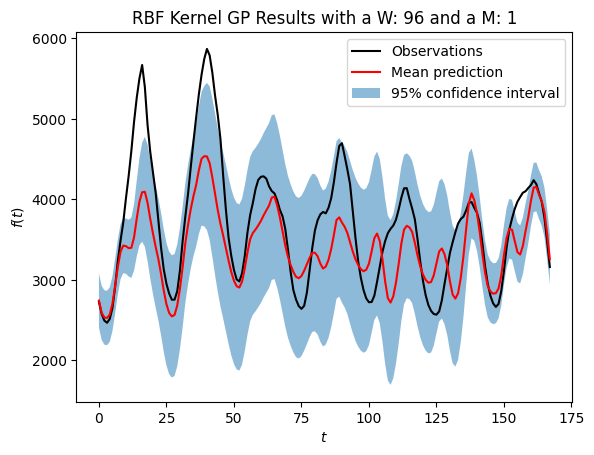

GP score on training data:  1.00
GP score on test data:      0.46
GP kernel:                  0.908**2 * RBF(length_scale=7.05) + WhiteKernel(noise_level=0.000181)


In [9]:
# Test Data from July 1, 2021 to July 7, 2021
RBFGP.import_data(df_data['2021_CT'], 182*24, 189*24)
RBFGP.scale_data(RBFGP.test_data)
RBFGP.predict_gp(RBFGP.test_data)
RBFGP.plot_gp_results("RBF Kernel")
RBFGP.gp_performance()

# Linear Kernel M = 6

In [10]:
# Training the GP with a linear kernel
LinearGP = SlidingGPR()

# Training Data from 0 to 1000 hrs
LinearGP.import_data(df_data['2020_CT'], 0, 1000, IsTrainDataSet=True) 
LinearGP.scale_data(LinearGP.training_data, IsTrainDataSet=True)

# Setting the window, lookahead, and overlap
window = 96
lookahead = 6 # M
overlap = 1
kernel = 1 * DotProduct() + WhiteKernel()

# Training the GP
LinearGP.train_gp(kernel, window, lookahead, overlap)

/Users/zacharymontoya/Services/anaconda3/envs/ECE517/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


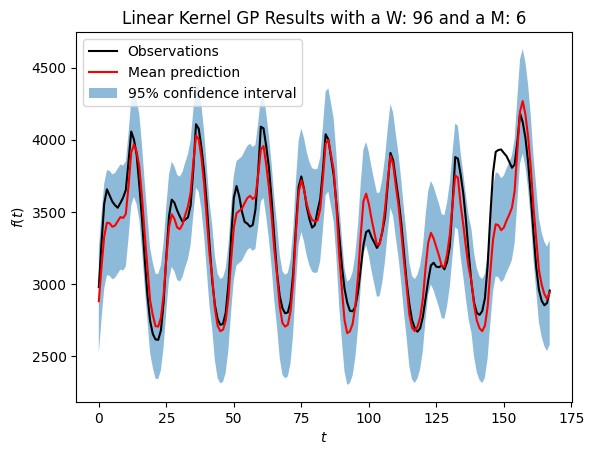

GP score on training data:  0.85
GP score on test data:      0.85
GP kernel:                  0.136**2 * DotProduct(sigma_0=0.523) + WhiteKernel(noise_level=0.0608)


In [11]:
# Test Data from January 1, 2021 to January 7, 2021
LinearGP.import_data(df_data['2021_CT'], 0, 24*7)
LinearGP.scale_data(LinearGP.test_data)
LinearGP.predict_gp(LinearGP.test_data)
LinearGP.plot_gp_results("Linear Kernel")
LinearGP.gp_performance()

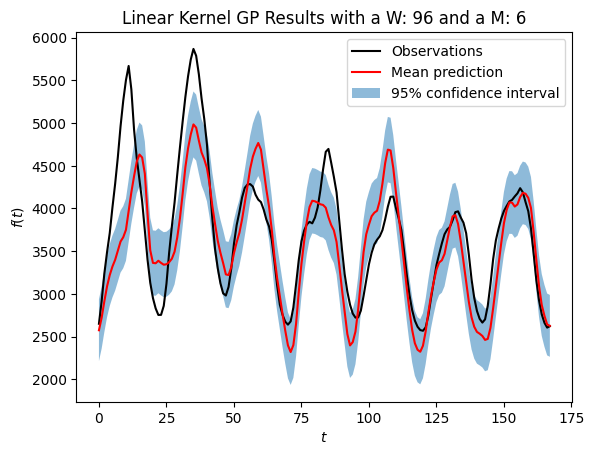

GP score on training data:  0.85
GP score on test data:      0.61
GP kernel:                  0.136**2 * DotProduct(sigma_0=0.523) + WhiteKernel(noise_level=0.0608)


In [12]:
# Test Data from July 1, 2021 to July 7, 2021
LinearGP.import_data(df_data['2021_CT'], 182*24, 189*24)
LinearGP.scale_data(LinearGP.test_data)
LinearGP.predict_gp(LinearGP.test_data)
LinearGP.plot_gp_results("Linear Kernel")
LinearGP.gp_performance()

# RBF Kernel M = 6

In [13]:
# Training the GP with a RBF kernel
RBFGP = SlidingGPR()

# Training Data from 0 to 1000 hrs
RBFGP.import_data(df_data['2020_CT'], 0, 1000, IsTrainDataSet=True) 
RBFGP.scale_data(RBFGP.training_data, IsTrainDataSet=True)

# Setting the window, lookahead, and overlap
window = 96
lookahead = 6 # M
overlap = 1
kernel = 1 * RBF() + WhiteKernel()

# Training the GP
RBFGP.train_gp(kernel, window, lookahead, overlap)

/Users/zacharymontoya/Services/anaconda3/envs/ECE517/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


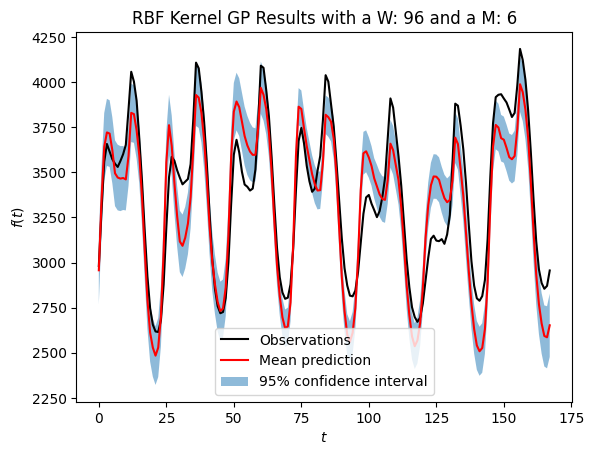

GP score on training data:  1.00
GP score on test data:      0.79
GP kernel:                  0.987**2 * RBF(length_scale=5.7) + WhiteKernel(noise_level=1e-05)


In [14]:
# Test Data from January 1, 2021 to January 7, 2021
RBFGP.import_data(df_data['2021_CT'], 0, 24*7)
RBFGP.scale_data(RBFGP.test_data)
RBFGP.predict_gp(RBFGP.test_data)
RBFGP.plot_gp_results("RBF Kernel")
RBFGP.gp_performance()

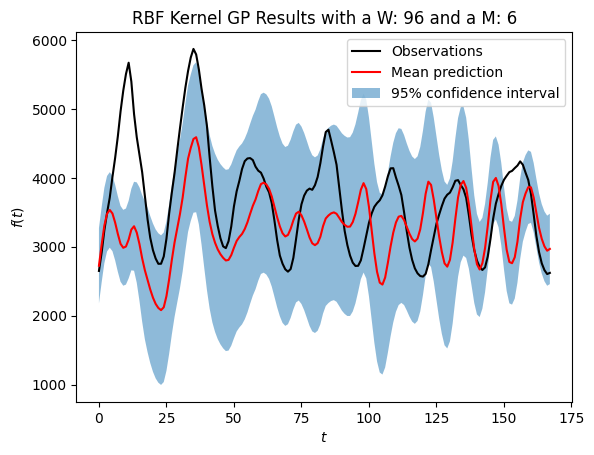

GP score on training data:  1.00
GP score on test data:      -0.20
GP kernel:                  0.987**2 * RBF(length_scale=5.7) + WhiteKernel(noise_level=1e-05)


In [15]:
# Test Data from July 1, 2021 to July 7, 2021
RBFGP.import_data(df_data['2021_CT'], 182*24, 189*24)
RBFGP.scale_data(RBFGP.test_data)
RBFGP.predict_gp(RBFGP.test_data)
RBFGP.plot_gp_results("RBF Kernel")
RBFGP.gp_performance()

# Linear Kernel M = 12

In [16]:
# Training the GP with a linear kernel
LinearGP = SlidingGPR()

# Training Data from 0 to 1000 hrs
LinearGP.import_data(df_data['2020_CT'], 0, 1000, IsTrainDataSet=True) 
LinearGP.scale_data(LinearGP.training_data, IsTrainDataSet=True)

# Setting the window, lookahead, and overlap
window = 96
lookahead = 12 # M
overlap = 1
kernel = 1 * DotProduct() + WhiteKernel()

# Training the GP
LinearGP.train_gp(kernel, window, lookahead, overlap)

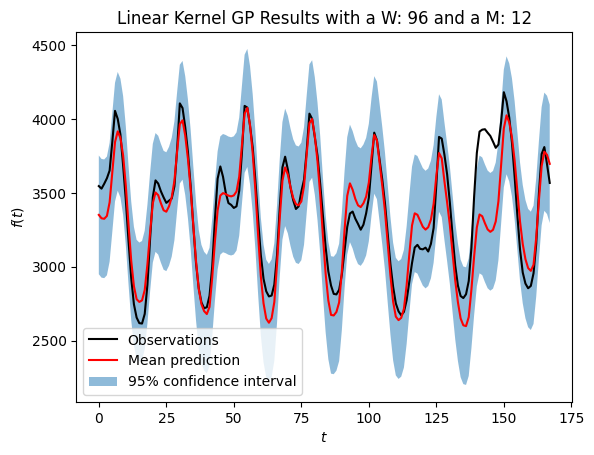

GP score on training data:  0.81
GP score on test data:      0.80
GP kernel:                  0.0907**2 * DotProduct(sigma_0=1.25) + WhiteKernel(noise_level=0.0753)


In [17]:
# Test Data from January 1, 2021 to January 7, 2021
LinearGP.import_data(df_data['2021_CT'], 0, 24*7)
LinearGP.scale_data(LinearGP.test_data)
LinearGP.predict_gp(LinearGP.test_data)
LinearGP.plot_gp_results("Linear Kernel")
LinearGP.gp_performance()

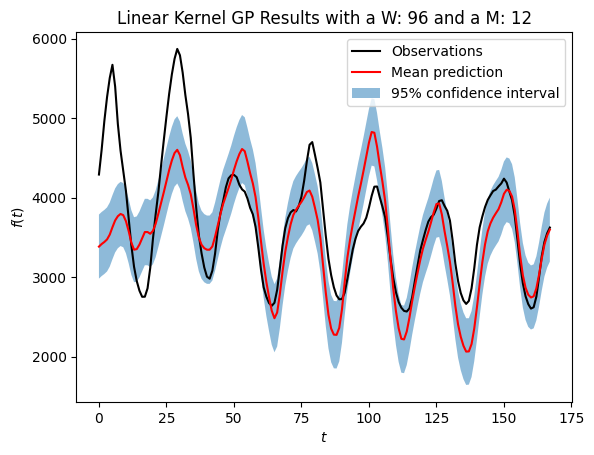

GP score on training data:  0.81
GP score on test data:      0.46
GP kernel:                  0.0907**2 * DotProduct(sigma_0=1.25) + WhiteKernel(noise_level=0.0753)


In [18]:
# Test Data from July 1, 2021 to July 7, 2021
LinearGP.import_data(df_data['2021_CT'], 182*24, 189*24)
LinearGP.scale_data(LinearGP.test_data)
LinearGP.predict_gp(LinearGP.test_data)
LinearGP.plot_gp_results("Linear Kernel")
LinearGP.gp_performance()

# RBF Kernel M = 12

In [19]:
# Training the GP with a RBF kernel
RBFGP = SlidingGPR()

# Training Data from 0 to 1000 hrs
RBFGP.import_data(df_data['2020_CT'], 0, 1000, IsTrainDataSet=True) 
RBFGP.scale_data(RBFGP.training_data, IsTrainDataSet=True)

# Setting the window, lookahead, and overlap
window = 96
lookahead = 12 # M
overlap = 1
kernel = 1 * RBF() + WhiteKernel()

# Training the GP
RBFGP.train_gp(kernel, window, lookahead, overlap)

/Users/zacharymontoya/Services/anaconda3/envs/ECE517/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


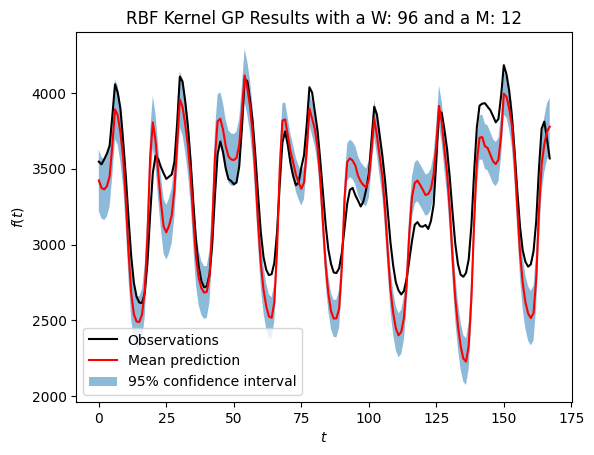

GP score on training data:  1.00
GP score on test data:      0.71
GP kernel:                  1.03**2 * RBF(length_scale=5.62) + WhiteKernel(noise_level=1e-05)


In [20]:
# Test Data from January 1, 2021 to January 7, 2021
RBFGP.import_data(df_data['2021_CT'], 0, 24*7)
RBFGP.scale_data(RBFGP.test_data)
RBFGP.predict_gp(RBFGP.test_data)
RBFGP.plot_gp_results("RBF Kernel")
RBFGP.gp_performance()

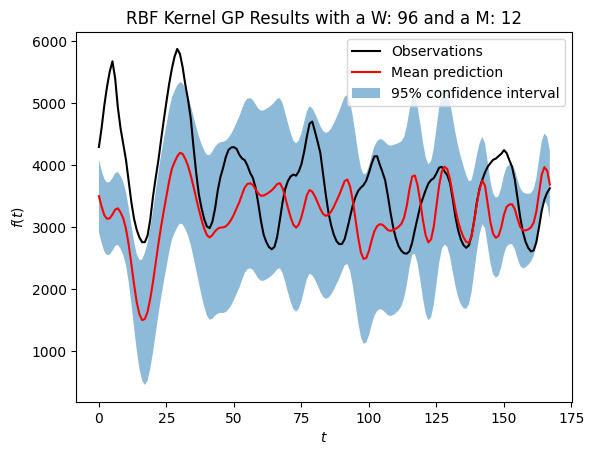

GP score on training data:  1.00
GP score on test data:      -0.39
GP kernel:                  1.03**2 * RBF(length_scale=5.62) + WhiteKernel(noise_level=1e-05)


In [21]:
# Test Data from July 1, 2021 to July 7, 2021
RBFGP.import_data(df_data['2021_CT'], 182*24, 189*24)
RBFGP.scale_data(RBFGP.test_data)
RBFGP.predict_gp(RBFGP.test_data)
RBFGP.plot_gp_results("RBF Kernel")
RBFGP.gp_performance()